This demonstration shows how [alpha compositing](https://en.wikipedia.org/wiki/Alpha_compositing)
can be done in 10 lines of code using
[OffsetArrays](https://github.com/JuliaArrays/OffsetArrays.jl) and
[PaddedViews](https://github.com/JuliaArrays/PaddedViews.jl)

In [1]:
using Images, MosaicViews
using OffsetArrays, PaddedViews # provide `OffsetArray` and `paddedviews`

## 1. basic offset and pad operation

Assume that we have two objects with transparent color and we want to place them on a canvas
with partially overlapping.

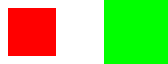

In [2]:
red_patch = fill(RGBA(1., 0., 0., 1), 24, 24)
green_patch = fill(RGBA(0., 1., 0., 1), 32, 32)
mosaicview(red_patch, green_patch; npad=20, nrow=1, fillvalue=colorant"white")

Assume the canvas axes starts from `(1, 1)`, here we keep the red patch unshifted,
and shift the green patch 6 pixels downward and 16 pixels rightward, and then
pad them to a common axes

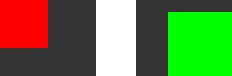

In [3]:
green_o = OffsetArray(green_patch, 6, 16)
r, g = paddedviews(Gray(0.2), red_patch, green_o)
mosaicview(r, g; npad=20, nrow=1, fillvalue=colorant"white")

Note that their axes and sizes are changed after shifting and padding:

In [4]:
# Regardless of implementaion details, `Base.OneTo(32)` is mostly equivalent to `1:32`
println("before shifting -- size: ", size(green_patch), " axes: ", axes(green_patch))
println("after shifting  -- size: ", size(green_o), " axes: ", axes(green_o))
println("after padding   -- size: ", size(g), " axes: ", axes(g))

before shifting -- size: (32, 32) axes: (Base.OneTo(32), Base.OneTo(32))
after shifting  -- size: (32, 32) axes: (7:38, 17:48)
after padding   -- size: (38, 48) axes: (1:38, 1:48)


Axes are preserved after padding, which means you can easily get original image from
padded results using

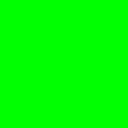

In [5]:
r[axes(red_patch)...]
g[axes(green_o)...]

As described [here](https://en.wikipedia.org/wiki/Alpha_compositing), there are several compositing
methods:

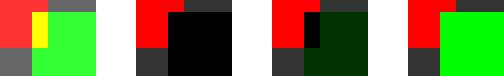

In [6]:
# add operation
out_add = r .+ g

# clear operation
out_clear = copy(r)
out_clear[axes(green_o)...] .= colorant"black"

# multiply operation
out_mul = copy(r)
# channel-wise multiplication
channelview(out_mul)[:, axes(green_o)...] .*= channelview(green_o)

# overlap operation
out_over = copy(r)
out_over[axes(green_o)...] .= green_o

# display the results of these operation
mosaicview(out_add, out_clear, out_mul, out_over;
           npad=20, nrow=1, fillvalue=colorant"white")

## 2. build the three-primary color panel

Now, let's use the same trick to build something more meaningful.
First we create three circles with colors red, green and blue

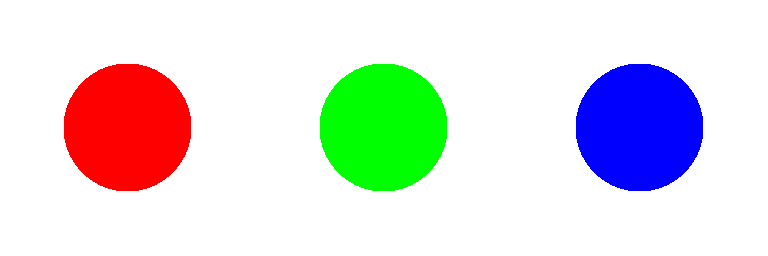

In [7]:
using ImageDraw
function make_circle(sz, c::T) where T
    # fill with transparent color to avoid black region
    fillvalue = ARGB(c)
    img = fill(ARGB{eltype(T)}(0., 0., 0., 0.), sz...)
    origin = sz .÷ 2
    r = sz .÷ 4
    draw!(img, Ellipse(origin..., r...), fillvalue)
    img
end

# create three circles with color red, green and blue
red_c   = make_circle((256, 256), ARGB(1., 0., 0., 1.))
green_c = make_circle((256, 256), ARGB(0., 1., 0., 1.))
blue_c  = make_circle((256, 256), ARGB(0., 0., 1., 1.))

mosaicview(red_c, green_c, blue_c; nrow=1)

Then, shift these circles to appropriate positions, pad them to common axes, and finally composite
using the add operation:

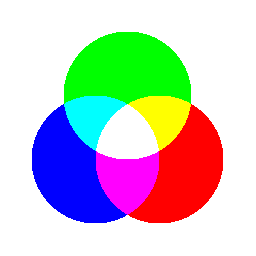

In [8]:
r = size(red_c, 1) ÷ 8
red_o   = OffsetArray(red_c,    r,  r)
green_o = OffsetArray(green_c, -r,  0)
blue_o  = OffsetArray(blue_c,   r, -r)

color_panel = sum(paddedviews(zero(eltype(red_o)), red_o, green_o, blue_o))
color_panel = color_panel[axes(red_c)...] # crop empty region

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*